## Predicting Airbnb new user booking
Team:
- Arun Reddy Nalla 
- Darun Arumugham
- Kedareshwara Kartikeya Rao Pagadala

## Index
1. Importing Libraries
2. Importing Dataset
3. Data Preprocessing
4. Data Visualization
5. Building prediction model
6. Conclusion

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import math
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier,ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import warnings 
warnings.filterwarnings("ignore")

## Importing Datasets

> Dataset: https://www.kaggle.com/competitions/airbnb-recruiting-new-user-bookings/data

In [2]:
#Importing the test, train and session dataset 
test_df=pd.read_csv("./Dataset/test_users.csv")
train_df=pd.read_csv("./Dataset/train_users_2.csv")
session_df=pd.read_csv("./Dataset/sessions.csv")

- Getting overview of test, train and session dataset files

In [3]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       62096 non-null  object 
 1   date_account_created     62096 non-null  object 
 2   timestamp_first_active   62096 non-null  int64  
 3   date_first_booking       0 non-null      float64
 4   gender                   62096 non-null  object 
 5   age                      33220 non-null  float64
 6   signup_method            62096 non-null  object 
 7   signup_flow              62096 non-null  int64  
 8   language                 62096 non-null  object 
 9   affiliate_channel        62096 non-null  object 
 10  affiliate_provider       62096 non-null  object 
 11  first_affiliate_tracked  62076 non-null  object 
 12  signup_app               62096 non-null  object 
 13  first_device_type        62096 non-null  object 
 14  first_browser         

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [5]:
session_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [6]:
session_df.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [7]:
#aggregating the user_id column and counting number of actions performed and seconds  user stayed
s_df = session_df.groupby(['user_id']).agg({'action':'count','secs_elapsed':'sum'}).reset_index()
s_df.head()

,user_id,action,secs_elapsed
0,00023iyk9l,39,867896.0
1,0010k6l0om,63,586543.0
2,001wyh0pz8,90,282965.0
3,0028jgx1x1,31,297010.0
4,002qnbzfs5,782,6487080.0


In [8]:
#Merging the dataset by session_df with training_df and dropping user id in training dataset 
user_df_train=train_df.merge(s_df, left_on=['id'],right_on=['user_id'],how='left').drop(['user_id'],axis=1).reset_index(drop=True)
user_df_train.shape

(213451, 18)

In [9]:
#Merging the dataset by session_df with testing_df and dropping user id in training dataset 
user_df_test=test_df.merge(s_df, left_on=['id'],right_on=['user_id'],how='left').drop(['user_id'],axis=1).reset_index(drop=True)
user_df_test.shape

(62096, 17)

In [10]:
user_df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,action,secs_elapsed
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,NaN,NaN
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,NaN,NaN
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,NaN,NaN
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,NaN,NaN
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,NaN,NaN


In [11]:
user_df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,action,secs_elapsed
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,8.0,119187.0
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,19.0,250119.0
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,58.0,975575.0
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE,11.0,123001.0
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,18.0,454023.0


## Data Processing

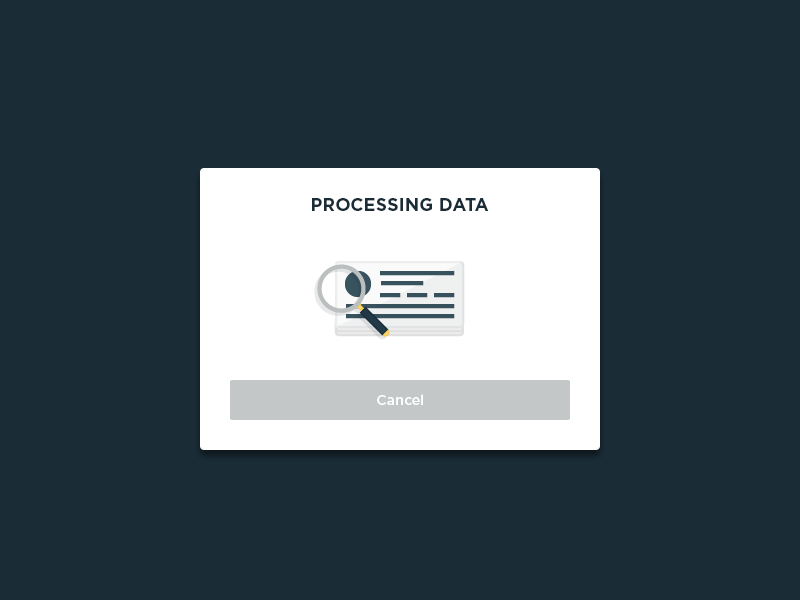

- Checking for Null values if any

In [12]:
user_df_train.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
action                     139636
secs_elapsed               139636
dtype: int64

In [13]:
user_df_test.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
action                       428
secs_elapsed                 428
dtype: int64

In [14]:
#Filling null data with -1 for secs_elapsed,action for training data
user_df_train.secs_elapsed.fillna(-1,inplace=True)
user_df_train.action.fillna(-1,inplace=True)
user_df_train.iloc[:,-11:]=user_df_train.iloc[:,-11:].fillna(-1)

user_df_train['secs_elapsed']=user_df_train['secs_elapsed'].astype('int64')
user_df_train['action']=user_df_train['action'].astype('int64')

In [15]:
#Filling null data with -1 for secs_elapsed,action for testing data
user_df_test.secs_elapsed.fillna(-1,inplace=True)
user_df_test.action.fillna(-1,inplace=True)
user_df_test.iloc[:,-11:]=user_df_test.iloc[:,-11:].fillna(-1)

user_df_test['secs_elapsed']=user_df_test['secs_elapsed'].astype('int64')
user_df_test['action']=user_df_test['action'].astype('int64')

In [16]:
#Calculating percentage of null data present 
user_df_train.isnull().sum()/user_df_train.shape[0] *100

id                          0.000000
date_account_created        0.000000
timestamp_first_active      0.000000
date_first_booking         58.347349
gender                      0.000000
age                        41.222576
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     0.000000
signup_app                  0.000000
first_device_type           0.000000
first_browser               0.000000
country_destination         0.000000
action                      0.000000
secs_elapsed                0.000000
dtype: float64

### Data Imputation

- Why need of data imputation? 

By above cell its is clear that we are having a majority of daya of 2 categories with empty data, to deal with this kind of problems data imputation is a recomended technique by majority of the programmers, apart from this all the data present in the dataset would br changed to similar form.

In [17]:
#imputing for training data
data_f=user_df_train.dropna(axis = 0, how = 'any')
print(user_df_train.shape)
print(data_f.shape)

(213451, 18)
(68532, 18)


- By the shape of training dataset and imputed dataset it is clear that the dataset is imbalanced

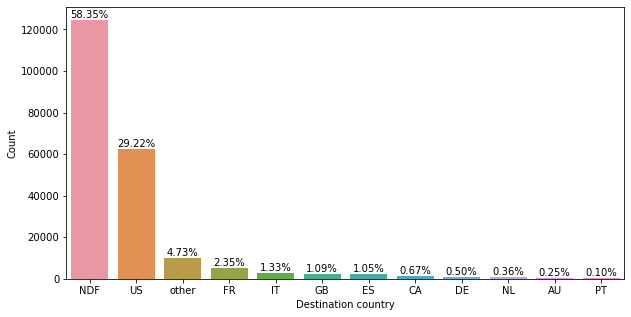

In [18]:
#Plotting country_destination graph
#cat1 -> cateogry 1 used to count country_destination
cat1 = user_df_train['country_destination'].value_counts()
#cat1 -> cateogry 2 used to index country_destination
cat2 = cat1.index
plt.figure(figsize=(10,5))
sns.countplot(user_df_train['country_destination'],order=cat2)
plt.xlabel('Destination country')
plt.ylabel('Count')
for i in range(cat1.shape[0]):
    count = cat1[i]
    strg = '{:0.2f}%'.format(100*count/user_df_train.shape[0])
    plt.text(i,count+1000,strg,ha='center')

#### Plotting the boxplot for age  to know the presence of outliers 

- Outliers increase the variability in your data, which decreases statistical power. Consequently, excluding outliers can cause your results to become statistically significant.


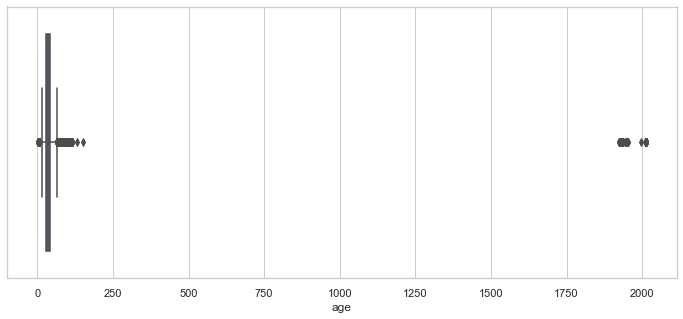

In [19]:
plt.figure(figsize=(12,5))
sns.set(style='whitegrid')
sns.boxplot(user_df_train['age'].dropna())
plt.show()

In [20]:
user_df_train['age'].describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [21]:
user_df_train['age'].median()

34.0

#### Reducing the data categories and setting the date format

In [22]:
# Training data

# clubbing gender values which have unknown and other 
user_df_train.gender.replace('-unknown-', 'OTHER', inplace=True)
#Combining the iOS and Android device values as SmartDevice
user_df_train.signup_app.replace(['iOS','Android'],'SmartDevice',inplace=True)
# filling null age values with median = 34
user_df_train['age'].fillna(34,inplace=True)
#adjusting the date format using lambda function
user_df_train['timestamp_first_active']=user_df_train['timestamp_first_active'].apply(lambda s:datetime(year=int(str(s)[0:4]),month=int(str(s)[4:6]),day=int(str(s)[6:8])).strftime('%Y-%m-%d'))
user_df_train['timestamp_first_active']=user_df_train['timestamp_first_active'].astype('datetime64[ns]')
#making sure all the data are set to same datatype (for age and time)
user_df_train['age']=user_df_train['age'].astype('int64')
user_df_train['date_account_created']=user_df_train['date_account_created'].astype('datetime64[ns]')
#creating year, month and day values 
user_df_train['dac_year']=user_df_train['date_account_created'].dt.year
user_df_train['dac_month']=user_df_train['date_account_created'].dt.month
user_df_train['dac_day']=user_df_train['date_account_created'].dt.day
#creating year, month and day timestamp values 
user_df_train['tfa_year']=user_df_train['timestamp_first_active'].dt.year
user_df_train['tfa_month']=user_df_train['timestamp_first_active'].dt.month
user_df_train['tfa_day']=user_df_train['timestamp_first_active'].dt.day
#dropping date_first_booking,date_account_created,timestamp_first_active,first_device_type,first_browser since we have replace them above
user_df_train.drop(['date_first_booking','date_account_created','timestamp_first_active','first_device_type','first_browser'],axis=1,inplace=True)

In [23]:
# Testing data

# clubbing gender values which have unknown and other 
user_df_test.gender.replace('-unknown-', 'OTHER', inplace=True)
#Combining the iOS and Android device values as SmartDevice
user_df_test.signup_app.replace(['iOS','Android'],'SmartDevice',inplace=True)
# filling null age values with median = 34
user_df_test['age'].fillna(34,inplace=True)
#adjusting the date format using lambda function
user_df_test['timestamp_first_active']=user_df_test['timestamp_first_active'].apply(lambda s:datetime(year=int(str(s)[0:4]), month=int(str(s)[4:6]), day=int(str(s)[6:8])).strftime('%Y-%m-%d'))
user_df_test['timestamp_first_active']=user_df_test['timestamp_first_active'].astype('datetime64[ns]')
#making sure all the data are set to same datatype (for age and time)
user_df_test['age']=user_df_test['age'].astype('int64')
user_df_test['date_account_created']=user_df_test['date_account_created'].astype('datetime64[ns]')
#creating year, month and day values 
user_df_test['dac_year']=user_df_test['date_account_created'].dt.year
user_df_test['dac_month']=user_df_test['date_account_created'].dt.month
user_df_test['dac_day']=user_df_test['date_account_created'].dt.day
#creating year, month and day timestamp values 
user_df_test['tfa_year']=user_df_test['timestamp_first_active'].dt.year
user_df_test['tfa_month']=user_df_test['timestamp_first_active'].dt.month
user_df_test['tfa_day']=user_df_test['timestamp_first_active'].dt.day
#dropping date_first_booking,date_account_created,timestamp_first_active,first_device_type,first_browser since we have replace them above
user_df_test.drop(['date_first_booking','date_account_created','timestamp_first_active','first_device_type','first_browser'],axis=1,inplace=True)

In [24]:
user_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   id                       213451 non-null  object
 1   gender                   213451 non-null  object
 2   age                      213451 non-null  int64 
 3   signup_method            213451 non-null  object
 4   signup_flow              213451 non-null  int64 
 5   language                 213451 non-null  object
 6   affiliate_channel        213451 non-null  object
 7   affiliate_provider       213451 non-null  object
 8   first_affiliate_tracked  213451 non-null  object
 9   signup_app               213451 non-null  object
 10  country_destination      213451 non-null  object
 11  action                   213451 non-null  int64 
 12  secs_elapsed             213451 non-null  int64 
 13  dac_year                 213451 non-null  int64 
 14  dac_month           

In [25]:
user_df_train.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,country_destination,action,secs_elapsed,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day
0,gxn3p5htnn,OTHER,34,facebook,0,en,direct,direct,untracked,Web,NDF,-1,-1,2010,6,28,2009,3,19
1,820tgsjxq7,MALE,38,facebook,0,en,seo,google,untracked,Web,NDF,-1,-1,2011,5,25,2009,5,23
2,4ft3gnwmtx,FEMALE,56,basic,3,en,direct,direct,untracked,Web,US,-1,-1,2010,9,28,2009,6,9
3,bjjt8pjhuk,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,other,-1,-1,2011,12,5,2009,10,31
4,87mebub9p4,OTHER,41,basic,0,en,direct,direct,untracked,Web,US,-1,-1,2010,9,14,2009,12,8


#### Working on age 

In [26]:
user_df_train['age'].describe()

count    213451.000000
mean         43.209444
std         119.592797
min           1.000000
25%          32.000000
50%          34.000000
75%          36.000000
max        2014.000000
Name: age, dtype: float64

- The min age value present in the dataset is 1 and max is 2014, which are technically invalid since a user age value should be between 18 to 100 or at max 110.

    i.e, age>=18 || age<=100 

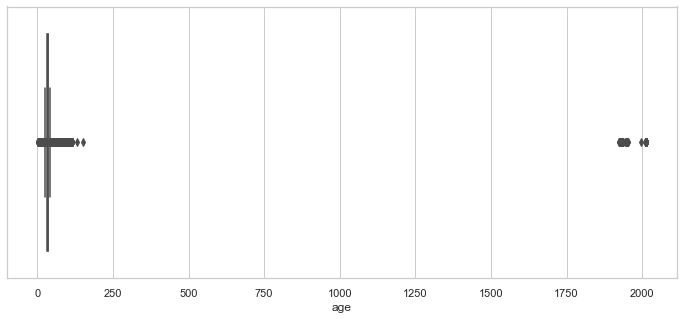

In [27]:
plt.figure(figsize=(12,5))
sns.set(style='whitegrid')
sns.boxplot(user_df_train['age'].dropna())
plt.show()

In [28]:
aged_train=user_df_train[(user_df_train.age>100)|(user_df_train.age<18)].count()
aged_train

id                         2503
gender                     2503
age                        2503
signup_method              2503
signup_flow                2503
language                   2503
affiliate_channel          2503
affiliate_provider         2503
first_affiliate_tracked    2503
signup_app                 2503
country_destination        2503
action                     2503
secs_elapsed               2503
dac_year                   2503
dac_month                  2503
dac_day                    2503
tfa_year                   2503
tfa_month                  2503
tfa_day                    2503
dtype: int64

In [29]:
aged_test=user_df_test[(user_df_test.age>100)|(user_df_test.age<18)].count()
aged_test

id                         375
gender                     375
age                        375
signup_method              375
signup_flow                375
language                   375
affiliate_channel          375
affiliate_provider         375
first_affiliate_tracked    375
signup_app                 375
action                     375
secs_elapsed               375
dac_year                   375
dac_month                  375
dac_day                    375
tfa_year                   375
tfa_month                  375
tfa_day                    375
dtype: int64

- The possible way to deal with this kind of situations is to either replace the value with  mean or median values, or eliminate them. 
   
- We have decided to remove these values since it would not be a feasible way to replace all the values with mean or median, it would effect the prediction of model.

In [30]:
#Dropping values from training data
user_df_train.drop(user_df_train[user_df_train['age'] < 18].index, inplace = True)
user_df_train.drop(user_df_train[user_df_train['age'] > 100].index, inplace = True)

In [31]:
aged_train=user_df_train[(user_df_train.age>100)|(user_df_train.age<18)].count()
aged_train

id                         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
country_destination        0
action                     0
secs_elapsed               0
dac_year                   0
dac_month                  0
dac_day                    0
tfa_year                   0
tfa_month                  0
tfa_day                    0
dtype: int64

In [32]:
#Dropping values from testing data
user_df_test.drop(user_df_test[user_df_test['age'] < 18].index, inplace = True)
user_df_test.drop(user_df_test[user_df_test['age'] > 100].index, inplace = True)

In [33]:
aged_test=user_df_test[(user_df_test.age>100)|(user_df_test.age<18)].count()
aged_test

id                         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
action                     0
secs_elapsed               0
dac_year                   0
dac_month                  0
dac_day                    0
tfa_year                   0
tfa_month                  0
tfa_day                    0
dtype: int64

#### Calculating Skewness for age

- Why Skewness?
   
   Since we want measure the shape of the data distributed we decided to use skew for the following problem and skip kurtosis as we are not focusing in the frequency of distribution.
    
   Skewness and values:
       - if skewness>0 left tail distributed.
       - if skewness=0 normally distributed.
       - if skewness<0 right tail distributed

In [34]:
user_df_train['age'].skew(skipna = True)

1.9545052740489377

- skewness>0 so we can say ir is a left distributed tail let us plot a graph to justify it.

(array([ 20180., 134181.,  26566.,  14050.,   8354.,   5262.,   1643.,
           367.,    159.,    186.]),
 array([ 18. ,  26.2,  34.4,  42.6,  50.8,  59. ,  67.2,  75.4,  83.6,
         91.8, 100. ]),
 <BarContainer object of 10 artists>)

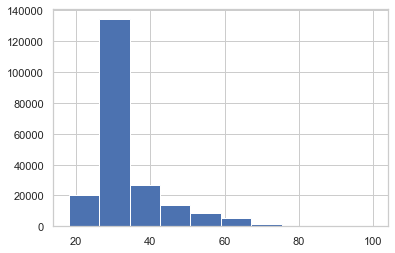

In [35]:
plt.hist(user_df_train['age'])

> Skewness for testing data

In [36]:
user_df_test['age'].skew(skipna = True)

1.8790078068434442

(array([8.6470e+03, 4.0891e+04, 5.7780e+03, 3.0950e+03, 1.8030e+03,
        1.0630e+03, 3.1700e+02, 6.5000e+01, 2.4000e+01, 3.8000e+01]),
 array([ 18. ,  26.2,  34.4,  42.6,  50.8,  59. ,  67.2,  75.4,  83.6,
         91.8, 100. ]),
 <BarContainer object of 10 artists>)

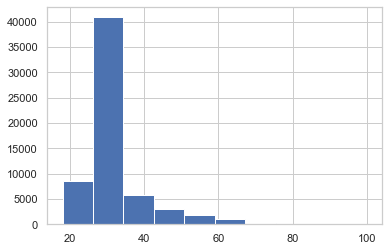

In [37]:
plt.hist(user_df_test['age'])

> Analysis on skewness for train and testing data 
- The skewness values for the training and testing data are 1.95 and 1.87 which are greater than 0, and this indicates that both the datasets are positively  skewed or left tail distributed.
- so we can fit these values close to normally distributed by making a own function which will replace data with log(x), where x is variable used to represnt or data 

In [38]:
#Normalizing age in training data
fu= user_df_train['age'].map(lambda x: math.log(x))
age_df_train = pd.DataFrame(data=fu,columns=['age'])
user_df_train['age'] =age_df_train['age']

In [39]:
#Normalizing age in testing data
fu= user_df_test['age'].map(lambda x: math.log(x))
age_df_test = pd.DataFrame(data=fu,columns=['age'])
user_df_test['age'] =age_df_test['age']

In [40]:
#Calculating new skew value for training and testing data
print(user_df_train['age'].skew(skipna = True))
print(user_df_test['age'].skew(skipna = True))

0.7650835733776832
0.45688067798914295


- By the above we can observe that the skew values which were 1.95 for traing data and 1.87 for testing are being brought to 0.43 and 0.45 which are equivalent to 0, and we can conclude that the data is now normally distributed.

(array([  3293.,  11843.,  28808., 115277.,  21706.,  14050.,   9134.,
          5390.,   1122.,    325.]),
 array([2.89037176, 3.0618516 , 3.23333144, 3.40481129, 3.57629113,
        3.74777097, 3.91925081, 4.09073066, 4.2622105 , 4.43369034,
        4.60517019]),
 <BarContainer object of 10 artists>)

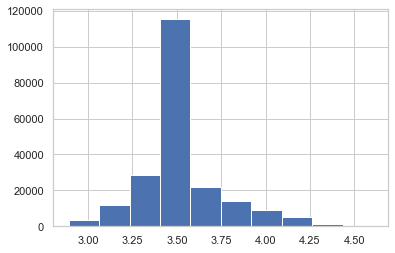

In [41]:
plt.hist(user_df_train['age'])

(array([ 2045.,  4901.,  8445., 35236.,  4689.,  3095.,  1961.,  1091.,
          200.,    58.]),
 array([2.89037176, 3.0618516 , 3.23333144, 3.40481129, 3.57629113,
        3.74777097, 3.91925081, 4.09073066, 4.2622105 , 4.43369034,
        4.60517019]),
 <BarContainer object of 10 artists>)

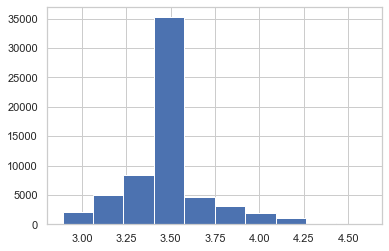

In [42]:
plt.hist(user_df_test['age'])

## Data Visualization

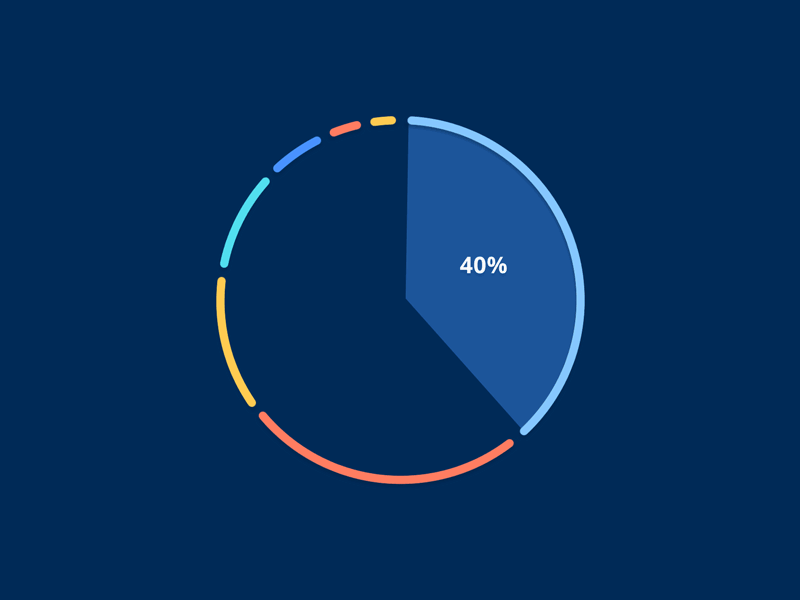 

## 1. Insights for destination country

In [43]:
## 1. Insights for destination countryprint('Total unique values in country_destination field :')
country_destination= train_df['country_destination'].value_counts()
print(country_destination)

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64


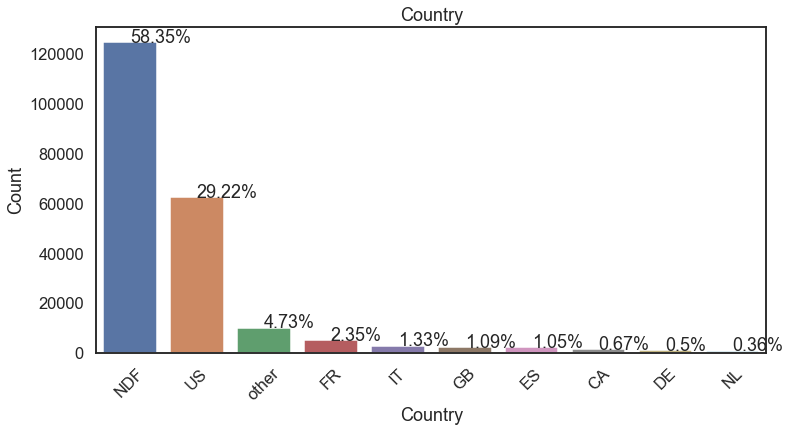

In [44]:
#Plotting the 'country_destination' field :

plt.figure(figsize=(12,6))
sns.set(style = 'white')
sns.set_context("talk")
sns.countplot('country_destination', data = train_df,order = train_df['country_destination'].value_counts().head(10).index)
for i in range(10):
    range_count = country_destination[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Country')
plt.show()

INSIGHTS

- The dataset is highly imbalanced. Over half of our customers (58.35%) have not made a reservation. There is a large share of users (29.22%) who have booked a destination in 'US' among those who have.

- Out of the countries given outside of the US, France ('FR') holds a high share of 2.35%. A significant percentage of users (4.73%) travelled to a destination that wasn't listed.

- The data indicates that US travellers are more likely to travel within the US.

# 2. Analysing the Gender Field

In [45]:
print('Total unique values in gender field :')
gender = train_df['gender'].value_counts()
print(gender)

Total unique values in gender field :
-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64


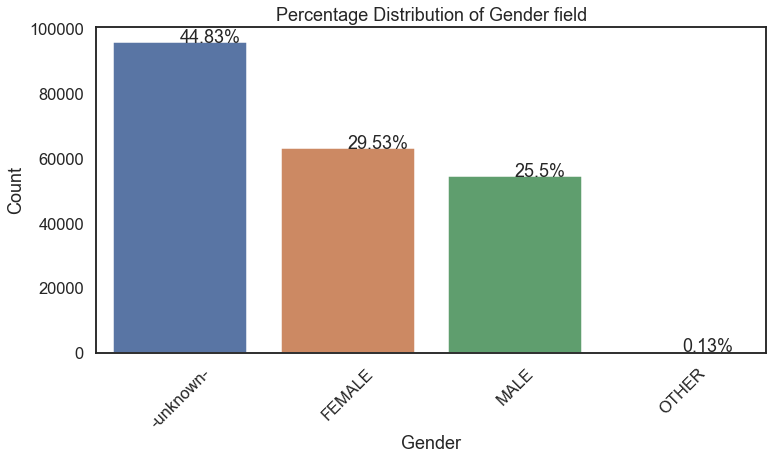

In [46]:
#Plotting Gender Field :

plt.figure(figsize=(12,6))
sns.set(style = 'white')
sns.set_context("talk")
sns.countplot('gender', data = train_df,order = train_df['gender'].value_counts().index)
for i in range(gender.shape[0]):
    range_count = gender[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Percentage Distribution of Gender field')
plt.show()

There are 4 major categories in gender field.

- It is reported that 44.83 percent of users have not disclosed their gender.
- There are marginally more female users than male users among those who have, with 29.53 % female users and 25.55 % male users.
- There are a small number of users (0.13%) who have selected 'other' as their gender.

Consequently, they are likely to be non-binary.

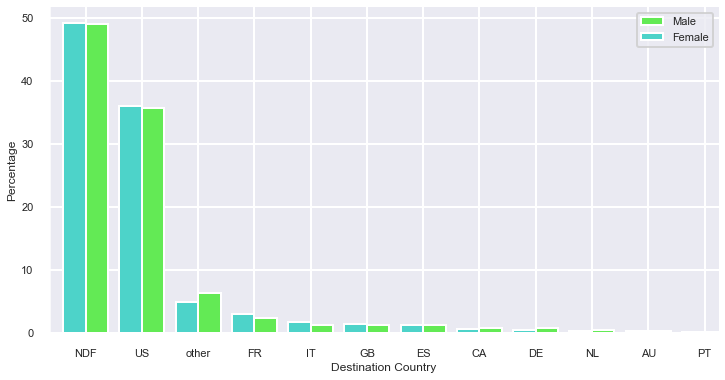

In [47]:
# Set figure aesthetics
sns.set_style("white")
sns.set(rc = {'figure.figsize':(12,6)})
sns.set_context("poster", font_scale=0.5)

women = sum(train_df['gender'] == 'FEMALE')
men = sum(train_df['gender'] == 'MALE')

female_destinations = train_df.loc[train_df['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = train_df.loc[train_df['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100

# Bar width
width = 0.4

male_destinations.plot(kind='bar', width=width, color='#63EA55', position=0, label='Male', rot=0)
female_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=1, label='Female', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

Findings :
There are no big differences between the 2 main genders, so this plot it's not really usseful except to know the relative destination frecuency of the countries.

# 3. Analysing Age

In [48]:
train_df['age'].isnull().sum()

87990

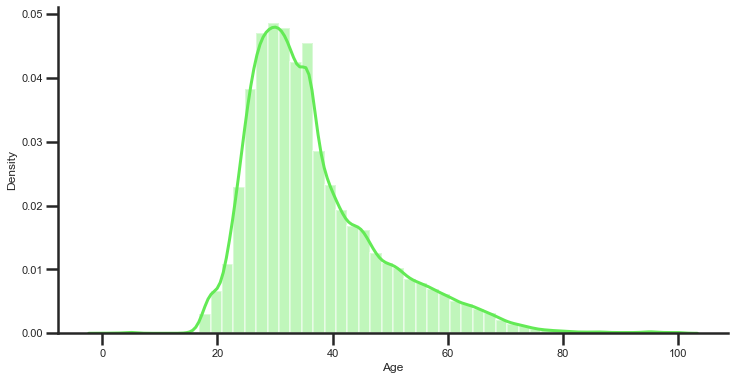

In [49]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
train_df['age']=train_df['age'].apply(lambda x : 36 if x>100 else x)
sns.distplot(train_df.age.dropna(), color='#63EA55')
plt.xlabel('Age')
sns.despine()


As expected, the common age to travel is between 25 and 40. Let's see if, for example, older people travel in a different way. Let's pick an arbitrary age to split into two groups. Maybe 35?

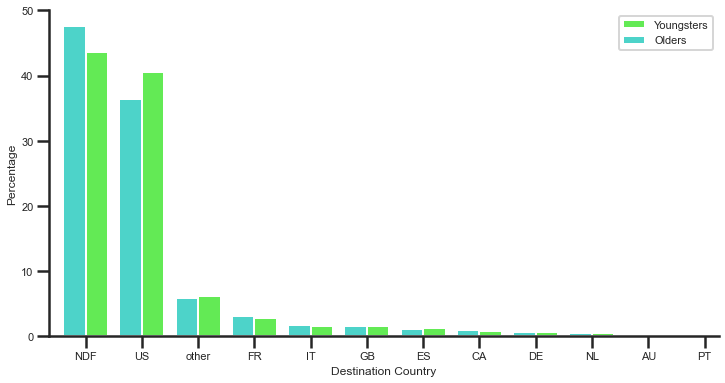

In [50]:
fig.set_size_inches(12,6)
age = 35

younger = sum(train_df.loc[train_df['age'] < age, 'country_destination'].value_counts())
older = sum(train_df.loc[train_df['age'] > age, 'country_destination'].value_counts())

younger_destinations = train_df.loc[train_df['age'] < age, 'country_destination'].value_counts() / younger * 100
older_destinations = train_df.loc[train_df['age'] > age, 'country_destination'].value_counts() / older * 100

younger_destinations.plot(kind='bar', width=width, color='#63EA55', position=0, label='Youngsters', rot=0)
older_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=1, label='Olders', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()


We can see that the young people tends to stay in the US, and the older people choose to travel outside the country. Of vourse, there are no big differences between them and we must remember that we do not have the 42% of the ages.

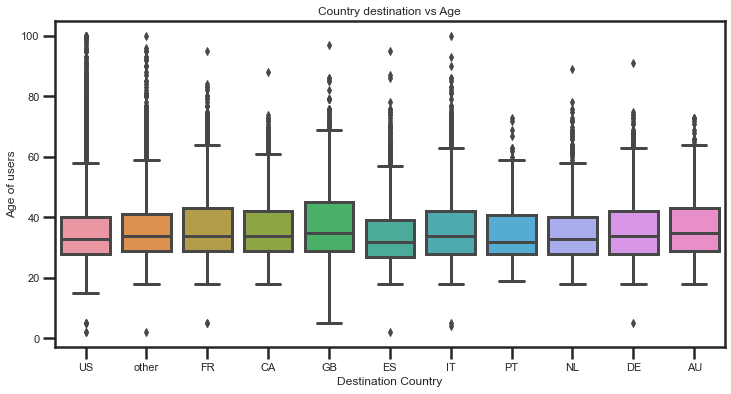

In [51]:
plt.figure(figsize=(12,6))
df_without_NDF =train_df[train_df['country_destination']!='NDF']
sns.boxplot(y='age' , x='country_destination',data=df_without_NDF)
plt.xlabel('Destination Country')
plt.ylabel('Age of users')
plt.title('Country destination vs Age')
plt.show()

there is no significant age difference among the users booking trips to the destinations displayed in the graph. However, the users booking trips to Great Britain seem to be relatively older than those booking trips to Spain and Netherlands.

# 4. Analysing Language

The majority of users' primary language is English (96.66%). Since the data comes from the US, this behaviour is very understandable given that the majority of people there identify English as their first language. This field is gave good insight as expected. There is no much analysis could be done in language field from the dataset.

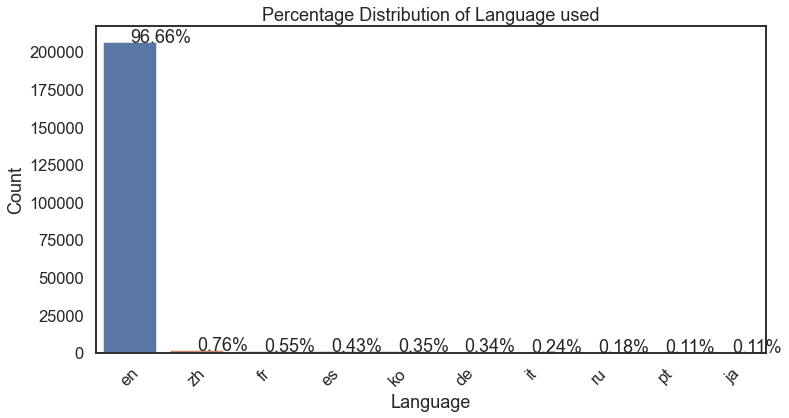

In [52]:
language = train_df['language'].value_counts()

#Plotting Language Field :

plt.figure(figsize=(12,6))
sns.set(style = 'white')
sns.set_context("talk")
sns.countplot('language', data = train_df,order = train_df['language'].value_counts().head(10).index)
for i in range(10):
    range_count = language[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Percentage Distribution of Language used')
plt.show()

The majority of users' primary language is English (96.66%). Since the data comes from the US, this behaviour is very understandable given that the majority of people there identify English as their first language. This field is gave good insight as expected. There is no much analysis could be done in language field from the dataset.

# 5. Analysing Signup method

In [53]:
print('Total unique values in signup_method field :')
signup_method = train_df['signup_method'].value_counts()
print(signup_method)

Total unique values in signup_method field :
basic       152897
facebook     60008
google         546
Name: signup_method, dtype: int64


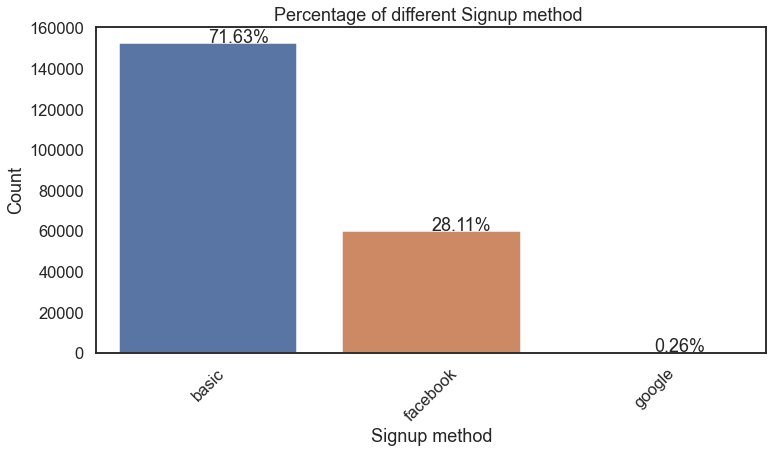

In [54]:
#Plotting signup_method field :

plt.figure(figsize=(12,6))
sns.set(style = 'white')
sns.set_context("talk")
sns.countplot('signup_method', data = train_df,order = train_df['signup_method'].value_counts().index)
for i in range(signup_method.shape[0]):
    range_count = signup_method[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Signup method')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Percentage of different Signup method ')
plt.show()

Majority of the users (71.63%) have used the basic method to create an account on the Airbnb application. This means that they have used the normal email-password as a method to signup. Among the remaining users, a huge majority (28.11%) have used facebook to signup. A very few percentage (0.26%) of people used google to signup.

This concludes that google is not much preferrred as a signup method. Also, it can mean that users are less inclined to share their personal information in the form of facebook or google linkup with their Airbnb account and hence they have chosen the basic email-password method to access their account.

# 6. Analysing the 'signup_app' field

In [55]:
print('Total unique values in signup_app field :')
signup_app = train_df['signup_app'].value_counts()
print(signup_app)


Total unique values in signup_app field :
Web        182717
iOS         19019
Moweb        6261
Android      5454
Name: signup_app, dtype: int64


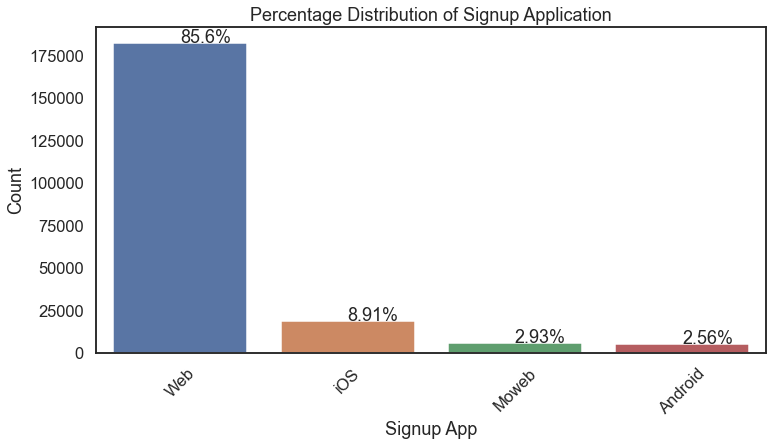

In [56]:
#Plotting the 'signup_app' field:

plt.figure(figsize=(12,6))
sns.set(style = 'white')
sns.set_context("talk")
sns.countplot('signup_app', data = train_df,order = train_df['signup_app'].value_counts().index)
for i in range(signup_app.shape[0]):
    range_count = signup_app[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Signup App')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Percentage Distribution of Signup Application')
plt.show()

Majority of the users (85.6%) used 'Web' to create the account. Among the remaining, 'iOS' is marginally more used (approx (5.98%) more) than 'Moweb' and 'Android'.

'Moweb' and 'Android' are not much popular apps to signup as it is used by an only 2.93% and 2.56% respectively of the users.

# 7. Analysing the device used

In [57]:
print('Total unique values in first_device_type field :')
first_device_type = train_df['first_device_type'].value_counts()
print(first_device_type)

Total unique values in first_device_type field :
Mac Desktop           89600
Windows Desktop       72716
iPhone                20759
iPad                  14339
Other/Unknown         10667
Android Phone          2803
Android Tablet         1292
Desktop (Other)        1199
SmartPhone (Other)       76
Name: first_device_type, dtype: int64


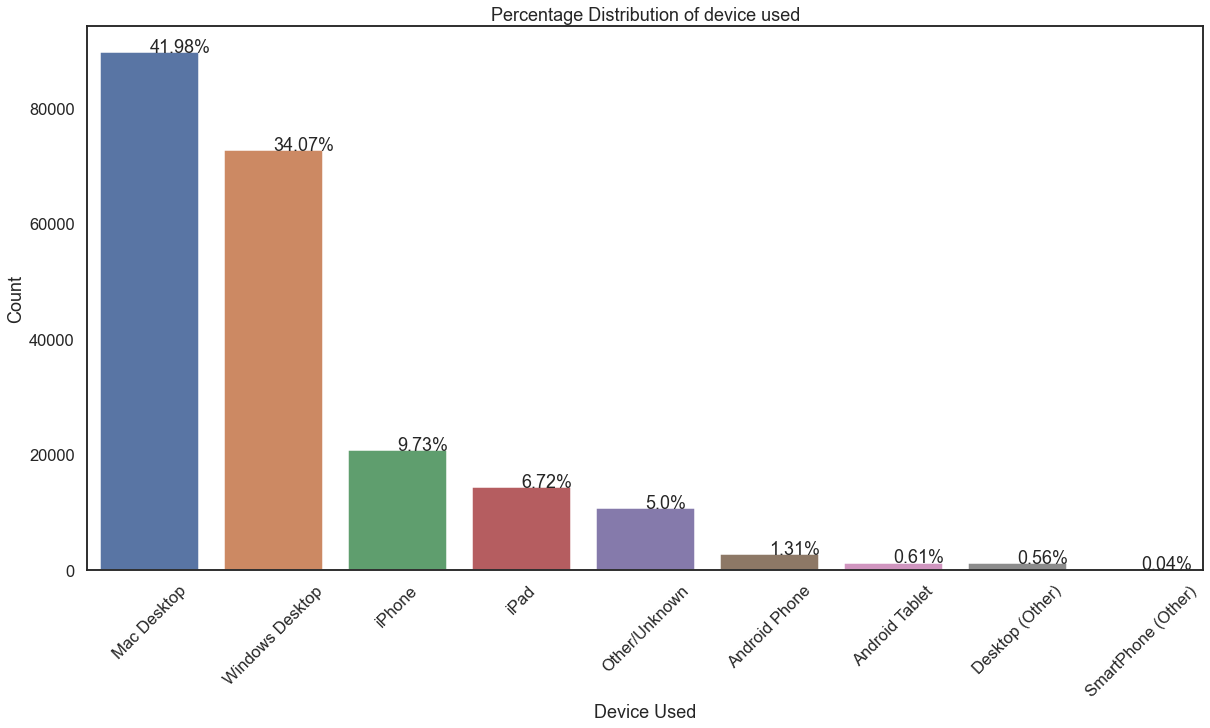

In [58]:
#Plotting the 'first_device_type' field :

plt.figure(figsize=(20,10))
sns.set(style = 'white')
sns.set_context("talk")
sns.countplot('first_device_type', data = train_df,order = train_df['first_device_type'].value_counts().index)
for i in range(first_device_type.shape[0]):
    range_count = first_device_type[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('Device Used')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Percentage Distribution of device used')
plt.show()

Most popular device that is used to create an account is 'Mac Desktop that is used by 41.98% of the customers. It is closely followed by 'Windows Desktop' with 34.07% of customers.

Among the remaining categories, 'iPhone' is more popular than 'Android Phone' in the mobile domain. Similarly, 'iPad' is more popular than 'Android Tablet' in the tablet domain.

Overall we can conclude from this plot that Apple products are more popular than Android ones across all categories (desktop,mobile,tablet).

# 8. Analysing the type of browser used

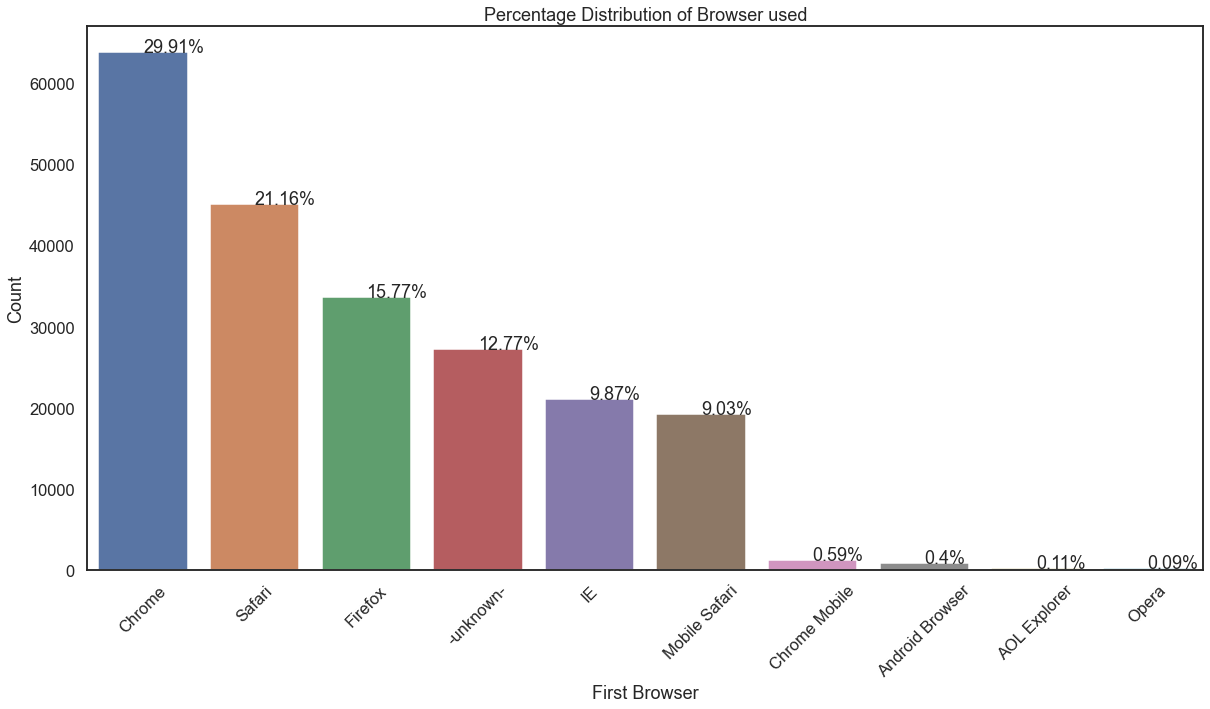

In [59]:
first_browser = train_df['first_browser'].value_counts()

#Plotting the 'first_browser' field :

plt.figure(figsize=(20,10))
sns.set(style = 'white')
sns.set_context("talk")
sns.countplot('first_browser', data = train_df,order = train_df['first_browser'].value_counts().head(10).index)
for i in range(10):
    range_count = first_browser[i]
    per = round(((range_count*100)/train_df.shape[0]),2)
    percent = '{}%'.format(per)
    plt.text(i,range_count,percent)
plt.xlabel('First Browser')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Percentage Distribution of Browser used')
plt.show()

This field tracks the first browser that the customer used to access the application. A large share (29.91%) is taken up by 'Chrome Browser' followed by 'Safari' at 21.16% and by 'Firefox' at 15.77%.

From the previous plot it is known that 'Mac Desktop' is the most popular device among the users. From this plot it is known that a large population of the customer prefered 'Chrome' as their browser even on their Apple products instead of Apple's own browser 'Safari'.

Another interesting fact is that for a considerable percentage (12.77%) of customer the first browser is not known.

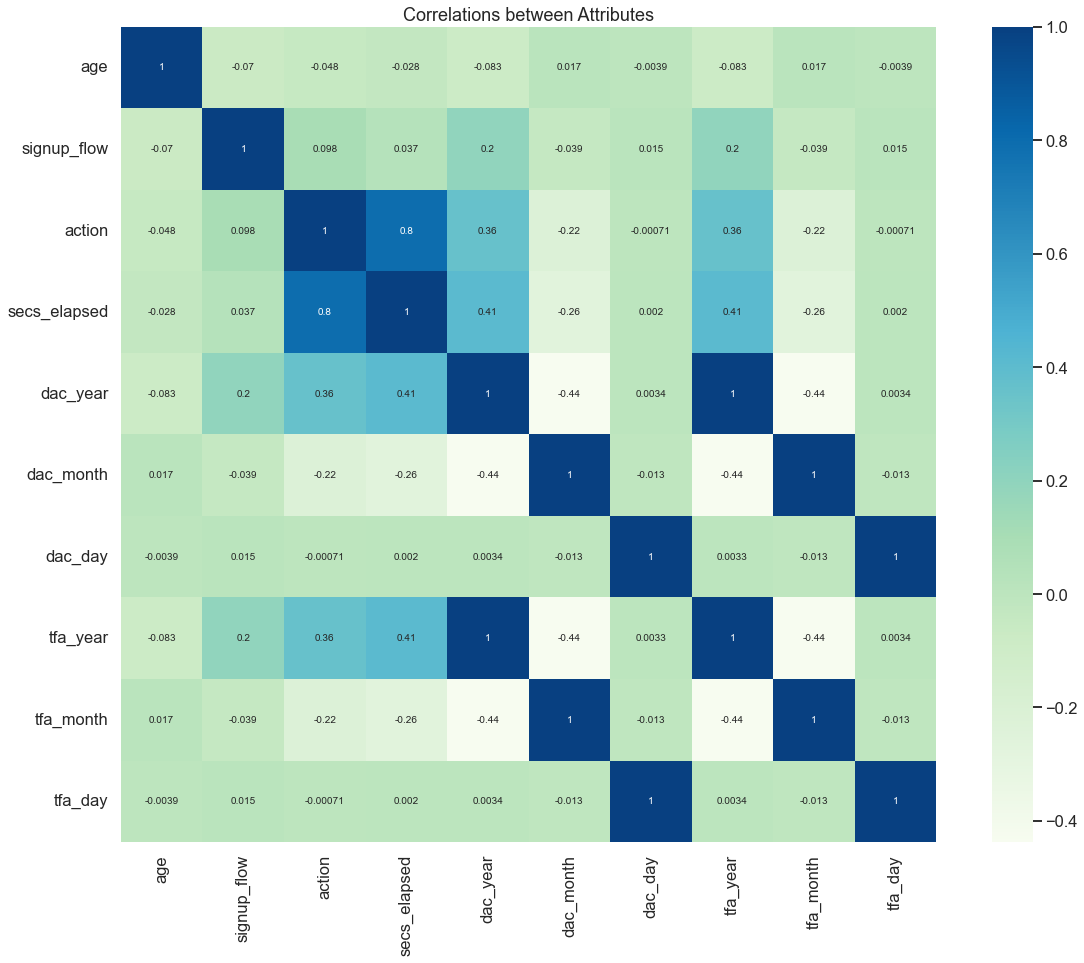

In [60]:
#correlation btw features and target variable by plotting heatmap:
fig = plt.subplots (figsize = (20, 15))
sns.heatmap(user_df_train.corr (), square = True, cbar = True, annot = True, cmap="GnBu", annot_kws = {'size': 10})
plt.title('Correlations between Attributes')
plt.show ()

In [61]:
#Dropping timestamps since these are not that useful as they have less correlation value
user_df_train.drop(['tfa_year','tfa_month','tfa_day'], axis = 1, inplace = True)
user_df_test.drop(['tfa_year','tfa_month','tfa_day'], axis = 1, inplace = True)

In [62]:
user_df_train.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,country_destination,action,secs_elapsed,dac_year,dac_month,dac_day
0,gxn3p5htnn,OTHER,3.526361,facebook,0,en,direct,direct,untracked,Web,NDF,-1,-1,2010,6,28
1,820tgsjxq7,MALE,3.637586,facebook,0,en,seo,google,untracked,Web,NDF,-1,-1,2011,5,25
2,4ft3gnwmtx,FEMALE,4.025352,basic,3,en,direct,direct,untracked,Web,US,-1,-1,2010,9,28
3,bjjt8pjhuk,FEMALE,3.737670,facebook,0,en,direct,direct,untracked,Web,other,-1,-1,2011,12,5
4,87mebub9p4,OTHER,3.713572,basic,0,en,direct,direct,untracked,Web,US,-1,-1,2010,9,14


In [63]:
user_df_test.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,action,secs_elapsed,dac_year,dac_month,dac_day
0,5uwns89zht,FEMALE,3.555348,facebook,0,en,direct,direct,untracked,Moweb,8,119187,2014,7,1
1,jtl0dijy2j,OTHER,3.526361,basic,0,en,direct,direct,untracked,Moweb,19,250119,2014,7,1
2,xx0ulgorjt,OTHER,3.526361,basic,0,en,direct,direct,linked,Web,58,975575,2014,7,1
3,6c6puo6ix0,OTHER,3.526361,basic,0,en,direct,direct,linked,Web,11,123001,2014,7,1
4,czqhjk3yfe,OTHER,3.526361,basic,0,en,direct,direct,untracked,Web,18,454023,2014,7,1


In [64]:
#Printing unique value count
z1=user_df_train.columns.map(lambda x: (len(user_df_train[x].value_counts())))
dfa=pd.DataFrame(z1,user_df_train.columns)
dfa

,0
id,210948
gender,3
age,83
signup_method,3
signup_flow,17
language,25
affiliate_channel,8
affiliate_provider,18
first_affiliate_tracked,8
signup_app,3


In [65]:
user_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210948 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       210948 non-null  object 
 1   gender                   210948 non-null  object 
 2   age                      210948 non-null  float64
 3   signup_method            210948 non-null  object 
 4   signup_flow              210948 non-null  int64  
 5   language                 210948 non-null  object 
 6   affiliate_channel        210948 non-null  object 
 7   affiliate_provider       210948 non-null  object 
 8   first_affiliate_tracked  210948 non-null  object 
 9   signup_app               210948 non-null  object 
 10  country_destination      210948 non-null  object 
 11  action                   210948 non-null  int64  
 12  secs_elapsed             210948 non-null  int64  
 13  dac_year                 210948 non-null  int64  
 14  dac_

## Building prediction model

#### data testing and training

In [66]:
#Spliting testing and training data
test_id = user_df_train.id
test_X = user_df_train.drop(['id'], axis='columns')

In [67]:
labels = user_df_train.country_destination
le = LabelEncoder()
train_y = le.fit_transform(labels) 

In [68]:
train_X = user_df_train.drop(['id','country_destination'], axis='columns')

In [69]:
train_X.shape,user_df_train.shape,len(train_y),user_df_train.shape

((210948, 14), (210948, 16), 210948, (210948, 16))

In [70]:
user_df_test.shape,test_X.shape

((61721, 15), (210948, 15))

In [71]:
n_classes = 12  # using sane classes as in Airbnb competition.
data, labels = make_classification(n_samples=2000, n_features=100, n_informative=50, n_classes=n_classes,  random_state=0)
#Spliting data into train and test sets of 30 and 70.
X, X_test, y, y_test = train_test_split(data, labels, test_size=0.30, random_state=0)

#### Support vector machine Accuracy

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       113
           1       0.88      0.95      0.92       120
           2       0.86      0.93      0.89       125
           3       0.90      0.93      0.92       121
           4       0.86      0.92      0.89       116
           5       0.92      0.89      0.91       122
           6       0.98      0.88      0.93       108
           7       0.94      0.83      0.88       109
           8       0.89      0.88      0.88       107
           9       0.94      0.93      0.93       120
          10       0.94      0.89      0.91       115
          11       0.88      0.94      0.91       124

    accuracy                           0.90      1400
   macro avg       0.91      0.90      0.90      1400
weighted avg       0.91      0.90      0.90      1400



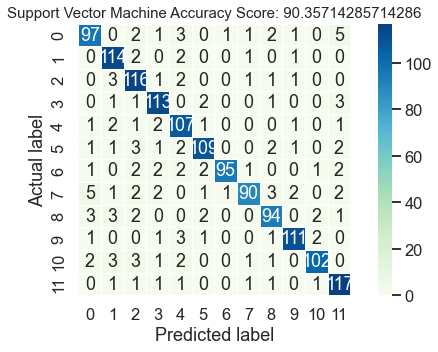

AxisError: axis 1 is out of bounds for array of dimension 1

In [72]:
clf = SVC(probability=True, random_state=0)
clf.fit(X, y)
clf.predict_proba(X_test)

try:
    y_pred = clf.predict(X)
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10,5))
    sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,cmap = 'GnBu',fmt='g')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Support Vector Machine Accuracy Score: {0}'.format(clf.score(X, y)*100)
    plt.title(all_sample_title, size = 15)
    plt.show()
except ValueError:
    pass
#ROC
y_proba = clf.predict_proba(X)[:,1]
print("SVM Roc AUC:", roc_auc_score(y, clf.predict_proba(X)[:,1],multi_class='ovo'))
fpr, tpr, thresholds = roc_curve(y, y_proba)
plt.plot(fpr, tpr,label='Support Vector Machine')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Random Forest ROC curve')
plt.legend(loc='best')
plt.show()

#### K Nearest Neighbour

              precision    recall  f1-score   support

           0       0.40      0.51      0.45       113
           1       0.50      0.48      0.49       120
           2       0.37      0.74      0.49       125
           3       0.54      0.55      0.54       121
           4       0.45      0.57      0.50       116
           5       0.45      0.53      0.49       122
           6       0.55      0.35      0.43       108
           7       0.73      0.29      0.42       109
           8       0.60      0.41      0.49       107
           9       0.53      0.39      0.45       120
          10       0.61      0.43      0.51       115
          11       0.57      0.53      0.55       124

    accuracy                           0.49      1400
   macro avg       0.53      0.48      0.48      1400
weighted avg       0.52      0.49      0.49      1400



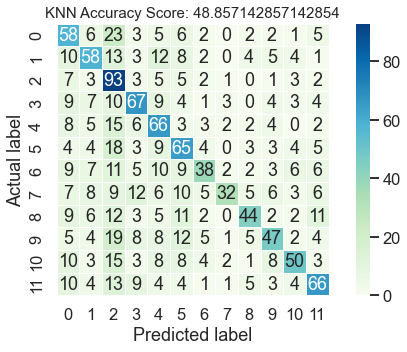

In [73]:
clf = KNeighborsClassifier(n_neighbors=30)
clf.fit(X, y)
clf.predict_proba(X_test)

y_pred = clf.predict(X)

print(classification_report(y, y_pred))
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(10,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'GnBu',fmt='g')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'KNN Accuracy Score: {0}'.format(clf.score(X, y)*100)
plt.title(all_sample_title, size = 15)
plt.show()

#### Gradient Boosting Classifier

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       113
           1       0.97      0.97      0.97       120
           2       0.96      0.98      0.97       125
           3       0.99      0.93      0.96       121
           4       0.97      0.97      0.97       116
           5       0.94      0.98      0.96       122
           6       0.99      0.96      0.98       108
           7       0.97      0.94      0.95       109
           8       0.97      0.97      0.97       107
           9       0.96      0.98      0.97       120
          10       0.98      0.94      0.96       115
          11       0.94      0.98      0.96       124

    accuracy                           0.96      1400
   macro avg       0.96      0.96      0.96      1400
weighted avg       0.96      0.96      0.96      1400



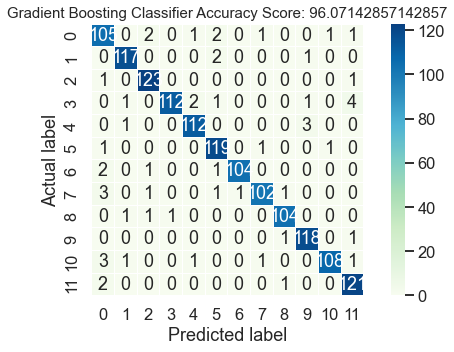

In [74]:
clf = GradientBoostingClassifier(n_estimators=50,random_state=0)
clf.fit(X, y)
clf.predict_proba(X_test)

y_pred = clf.predict(X)

print(classification_report(y, y_pred))
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(10,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'GnBu',fmt='g')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Gradient Boosting Classifier Accuracy Score: {0}'.format(clf.score(X, y)*100)
plt.title(all_sample_title, size = 15)
plt.show()

#### Extra Trees Classifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       1.00      1.00      1.00       120
           2       1.00      1.00      1.00       125
           3       1.00      1.00      1.00       121
           4       1.00      1.00      1.00       116
           5       1.00      1.00      1.00       122
           6       1.00      1.00      1.00       108
           7       1.00      1.00      1.00       109
           8       1.00      1.00      1.00       107
           9       1.00      1.00      1.00       120
          10       1.00      1.00      1.00       115
          11       1.00      1.00      1.00       124

    accuracy                           1.00      1400
   macro avg       1.00      1.00      1.00      1400
weighted avg       1.00      1.00      1.00      1400



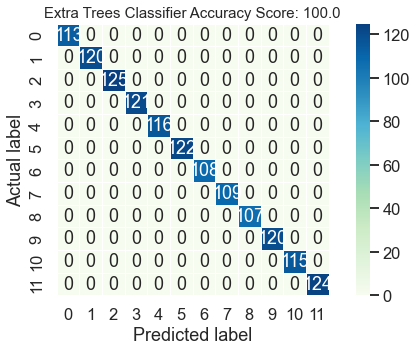

In [75]:
clf = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=0)
clf.fit(X, y)
clf.predict_proba(X_test)

y_pred = clf.predict(X)

print(classification_report(y, y_pred))
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(10,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'GnBu',fmt='g')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Extra Trees Classifier Accuracy Score: {0}'.format(clf.score(X, y)*100)
plt.title(all_sample_title, size = 15)
plt.show()

## Conclusion

- We have performed several operationsfor provided dataset from Kaggle https://www.kaggle.com/competitions/airbnb-recruiting-new-user-bookings/data 
- While exploring the datset we discoverd several data present in the dataset were empty and invalid data for example there are case where user age is between 1 and age>100, which is technically not possible, so in order to make the predictions and dataset more real like we have used techniques like droping and replacing the data with median or mode.
- We have sucessfully performed data visualization and plotted correlation between the attributes of the combined dataset, as a final step we have divided the data for testing and training after which we have used various algorithms like support vector machine, k nearest neighbours, gradient boosting classifier and extra trees classifer where we got highest accuracy for gradient boosting classifer. 

#### future Scope
- This kind of datasets analysis and model building could play a crucial role when an organization wants to know how a new user is going to use their servies and based on the user preferences and usage of user, we can target customized deals or features for user which would increase the scope of attracting users to the services.